# Springboard Capstone 2: 
## Covid-19 Wastewater Surveillance Prediction
### Author: Nantawat Samermit

## Executive Summary

### Problem:
The Sars-CoV-19 or 'Covid-19' virus is an ongoing pandemic. Businesses and communities are being affected with each wave. Wastewater surveillance is a non-invasive way to measure mRNA concentrations of the virus.

### Exploratory Research Question:
Can we use the viral concentration surveilled from wastewater to predict a surge?


### Methods
    Rationale for Method

### Results

### Implications

# Data Scraping (Unit 7.2)
I'll be scraping three datasets. 

The first is from the Cambridge MA wastewater data archive. It is listed as JSON, which I will convert to a pandas DataFrame. 

The URL is here: 'https://data.cambridgema.gov/resource/ayt4-g2ye.json'


The second dataset is from Massachusetts Department of Health. 

The URL is here: 'https://www.mass.gov/doc/covid-19-raw-data-june-15-2021/download'

The third dataset is from Biobot's Github: https://github.com/biobotanalytics/covid19-wastewater-data/blob/master/wastewater_by_county.csv

I downloaded the third dataset from Github and added it to the Biobot Data folder.

In [1]:
#import relevant modules for data wrangling - keep on adding as needed
import pandas as pd
import json, requests
import fuzzywuzzy 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import preprocessing

## Notes regarding Massachusetts Data
After some attempts, it seems the Massachusetts dataset is a multi-page csv, and it isn't easily accessible.

I will have to use BeautifulSoup to isolate the link to the excel file.

In [2]:
from bs4 import BeautifulSoup
from urllib.request import urlopen, Request

In [3]:
# Use BS to identify/isolate the html "class" pointing to the href of the .xls 
#class and "ma__download-link__file-link" was identified by inspecting the page's elements in chrome
source = requests.get("https://www.mass.gov/doc/covid-19-raw-data-july-29-2021")
BeautifulSoup(source.content).find("a", {"class":"ma__download-link__file-link"}).get("href")

'/doc/covid-19-raw-data-july-29-2021/download'

BeautifulSoup has isloated the href link for the .xls spreadsheet. 

It is here: https://www.mass.gov/doc/covid-19-raw-data-july-29-2021/download

## Scrape, Download, and Save datasets
I will write a function to scrape, convert, and save both datasets to my directory as pickle files. 

In [4]:
#Luka states it is easier (and acceptable) to just download the files to local path. 

#For the mass.gov dataset, it has mulitiple sheets, so it isolates the intended sheet. (not dynamic, ikr)

def get_sources(source_list):
    '''
    this function takes a list of urls, ID's their format, requests dataset from source,
    converts data into a dataframe, then saves it as a pickled file.
    '''
    for counter, source in enumerate(source_list):
        name = str(counter) + '_df.pkl'

        if source.endswith('.json'):
            response = requests.get(source)
            data = response.json()
            json_df = pd.DataFrame(data)            
            json_df.to_pickle(name)
            
        
        elif source.endswith('.csv'):
            csv = pd.read_csv(source, engine='python')
            csv.to_pickle(name)
            
        else:
            response = requests.get(source, allow_redirects=True)
            with open('excel_data.xlsx', 'wb') as file:
                file.write(response.content)
            
            #using pd.read_excel on a multi-spreadsheet xls yields a dictionary
            excel_dict = pd.read_excel('excel_data.xlsx', sheet_name=None)
            name = str(counter) + '_df.pkl'
            #can ID sheetnames by evaluating keys
            #print(excel_dict.keys())
            if len(excel_dict.keys()) > 1:
                print('There are more than one sheet in this .csv file.','\n',
                      source, '\n', excel_dict.keys())
                myInput = input('Which of these sheets do  you want to use?')
                #print(myInput)
                excel_specified_sheet = excel_dict[myInput]
                excel_specified_sheet.to_pickle(name)
            else:
                excel_dict.to_pickle(name)
            
        print(name,' created using this source', source)

In [6]:
sources = ['https://data.cambridgema.gov/resource/ayt4-g2ye.json', 
           'https://www.mass.gov/doc/covid-19-raw-data-july-29-2021/download',
           'Biobot Data/wastewater_by_county.csv' 
          ]

#old_source = 'https://www.mass.gov/doc/covid-19-raw-data-june-15-2021/download'

get_sources(sources)

0_df.pkl  created using this source https://data.cambridgema.gov/resource/ayt4-g2ye.json
There are more than one sheet in this .csv file. 
 https://www.mass.gov/doc/covid-19-raw-data-july-29-2021/download 
 dict_keys(['Data Documentation', 'Weekly_Town_Reference', 'Age Means Last2Weeks', 'AgeLast2Weeks', 'Cases (Report Date)', 'CasesbyAge', 'CasesByDate (Test Date)', 'CasesByDate_Probable', 'County_Daily', 'County_Weekly', 'CountyDeaths', 'DateofDeath', 'DeathsReported (Report Date)', 'DeathCharacteristics', 'HigherEd_CasesandTests', 'HospBedAvailable-Regional', 'HospBed-Hospital COVID Census', 'Hospitalization from Hospitals', 'LTC Facilities', 'RaceEthnicityLast2Weeks', 'SexLast2Weeks', 'Testing2 (Report Date)', 'TestingByDate (Test Date)', 'TestingPosByAge', 'Weekly_City_Town', 'Weekly_Statewide', 'Clusters', 'Isolation and Quarantine', 'Contact Tracing', 'CTC workforce', 'Counts by Specimen Date (Sero)'])
Which of these sheets do  you want to use?Weekly_City_Town
1_df.pkl  created 

## Use pickle to confirm the saved files can be loaded in Jupyter

In [7]:
import pickle

In [8]:
#should use context manager to load pickles 
# Don't forget to state 'rb' param or will get an Unicode Error.

    
with open('0_df.pkl', 'rb') as f:
    Cambridge_df = pickle.load(f)
    
with open('1_df.pkl', 'rb') as f:
    Mass_df = pickle.load(f)

with open('2_df.pkl', 'rb') as f:
    Biobot_df = pickle.load(f)

In [9]:
#testing both dataframes
Cambridge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   date                          309 non-null    object
 1   mwra_concentration            309 non-null    object
 2   mwra_7dayaverage              309 non-null    object
 3   concentration_mid_cambridge   309 non-null    object
 4   concentration_east_cambridge  309 non-null    object
 5   concentration_cambridgeport   309 non-null    object
 6   concentration_north_west      309 non-null    object
 7   highci_mid_cambridge          309 non-null    object
 8   highci_east_cambridge         309 non-null    object
 9   highci_cambridgeport          309 non-null    object
 10  highci_north_west_cambridge   309 non-null    object
 11  lowci_mid_cambridge           309 non-null    object
 12  lowci_east_cambridge          309 non-null    object
 13  lowci_cambridgeport 

In [10]:
Mass_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11296 entries, 0 to 11295
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   City/Town                   11296 non-null  object        
 1   County                      11296 non-null  object        
 2   Population                  11296 non-null  object        
 3   Total Case Counts           11296 non-null  object        
 4   Two Week Case Counts        11296 non-null  object        
 5   Average Daily Rate          11296 non-null  object        
 6   Color                       9495 non-null   object        
 7   Change in Last Week         11296 non-null  object        
 8   Total Tests                 11296 non-null  int64         
 9   Total Tests Last Two Weeks  11295 non-null  float64       
 10  Total Positive Tests        11295 non-null  float64       
 11  Percent Positivity          11295 non-null  object    

In [11]:
Biobot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1267 entries, 0 to 1266
Data columns (total 7 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   sampling_week                             1267 non-null   object 
 1   normalized_concentration_rolling_average  1267 non-null   float64
 2   population                                1267 non-null   object 
 3   region                                    1267 non-null   object 
 4   state                                     1267 non-null   object 
 5   county_fips_code                          1267 non-null   int64  
 6   county_name                               1267 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 69.4+ KB


# Data Wrangling (Unit 7.2)
Explore the dataset. Understand the datatypes for the various columns, and confirm that there are no missing values.

## Cambridge Data

In [12]:
Cambridge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   date                          309 non-null    object
 1   mwra_concentration            309 non-null    object
 2   mwra_7dayaverage              309 non-null    object
 3   concentration_mid_cambridge   309 non-null    object
 4   concentration_east_cambridge  309 non-null    object
 5   concentration_cambridgeport   309 non-null    object
 6   concentration_north_west      309 non-null    object
 7   highci_mid_cambridge          309 non-null    object
 8   highci_east_cambridge         309 non-null    object
 9   highci_cambridgeport          309 non-null    object
 10  highci_north_west_cambridge   309 non-null    object
 11  lowci_mid_cambridge           309 non-null    object
 12  lowci_east_cambridge          309 non-null    object
 13  lowci_cambridgeport 

In [13]:
Cambridge_df.describe()

,date,mwra_concentration,mwra_7dayaverage,concentration_mid_cambridge,concentration_east_cambridge,concentration_cambridgeport,concentration_north_west,highci_mid_cambridge,highci_east_cambridge,highci_cambridgeport,highci_north_west_cambridge,lowci_mid_cambridge,lowci_east_cambridge,lowci_cambridgeport,lowci_north_west_cambridge
count,309,309,309,309,309,309,309,309,309,309,309,309,309,309,309
unique,309,243,228,30,36,27,34,30,36,27,34,30,36,27,34
top,2021-02-17T00:00:00.000,,20,,,,,,,,,,,,
freq,1,11,6,273,271,275,271,273,271,275,271,273,271,275,271


# Note to myself:
For my own review!

Column Definitions:
Date - sample date for 24 hour composite sample


MWRA_Concentration - Normalized SARS-CoV2 RNA Copies per ML collected during sampling period.


MWRA_7DayAverage - 7 day rolling average for Normalized SARS-CoV2 RNA Copies per ML collected during sampling period.


Concentration_* - Normalized SARS-CoV2 RNA Copies per ML collected during sampling period.


highci_* - Upper Limit on Confidence Interval for Normalized SARS-CoV2 RNA Copies per ML collected during sampling period.


lowci_* - Lower Limit on Confidence Interval for Normalized SARS-CoV2 RNA Copies per ML collected during sampling period.
* means there are multiple columns with this prefix which share the same definition - Nantawat

A refresher on confidence interval limits - https://bit.ly/3vtuI7h


## Features observations:
1. All the features pf Cambridge_df are object dtypes.
2. describe() states they (15 features) are all non-null values. Let's confirm that.

In [14]:
#This confirms that none of the features contain null values. 
Cambridge_df.isnull().sum()

date                            0
mwra_concentration              0
mwra_7dayaverage                0
concentration_mid_cambridge     0
concentration_east_cambridge    0
concentration_cambridgeport     0
concentration_north_west        0
highci_mid_cambridge            0
highci_east_cambridge           0
highci_cambridgeport            0
highci_north_west_cambridge     0
lowci_mid_cambridge             0
lowci_east_cambridge            0
lowci_cambridgeport             0
lowci_north_west_cambridge      0
dtype: int64

In [15]:
#This will show that although isnull().sum() returns 0 null values, the cells look blank!
Cambridge_df.head(5)

,date,mwra_concentration,mwra_7dayaverage,concentration_mid_cambridge,concentration_east_cambridge,concentration_cambridgeport,concentration_north_west,highci_mid_cambridge,highci_east_cambridge,highci_cambridgeport,highci_north_west_cambridge,lowci_mid_cambridge,lowci_east_cambridge,lowci_cambridgeport,lowci_north_west_cambridge
0,2020-10-01T00:00:00.000,,31,,,,,,,,,,,,
1,2020-10-02T00:00:00.000,34,31,,,,,,,,,,,,
2,2020-10-03T00:00:00.000,,31,,,,,,,,,,,,
3,2020-10-04T00:00:00.000,,31,,,,,,,,,,,,
4,2020-10-05T00:00:00.000,38,30,,,,,,,,,,,,


In [16]:
#Just incase I need to examine this data one day... 
Cambridge_non_blank_data = pd.DataFrame(Cambridge_df.loc[Cambridge_df['concentration_mid_cambridge'] != ''])

### This does not pass the stench test! mwra_concentration is not 100% non-null

In [17]:
#Check these blank cells to confirm they are 'filled' with whitespaces
Cambridge_df['mwra_concentration'][0] == ''

True

In [18]:
#create a method using the logic from the cell above to check for blank cells
def blank_check(df):
    ''' A method to check my column cells from a pandas DataFrame for whitespace blanks.'''
    return dict(zip(df.columns, [(df[x] == '').sum() for x in df.columns]))

In [19]:
blank_check(Cambridge_df)

{'date': 0,
 'mwra_concentration': 11,
 'mwra_7dayaverage': 0,
 'concentration_mid_cambridge': 273,
 'concentration_east_cambridge': 271,
 'concentration_cambridgeport': 275,
 'concentration_north_west': 271,
 'highci_mid_cambridge': 273,
 'highci_east_cambridge': 271,
 'highci_cambridgeport': 275,
 'highci_north_west_cambridge': 271,
 'lowci_mid_cambridge': 273,
 'lowci_east_cambridge': 271,
 'lowci_cambridgeport': 275,
 'lowci_north_west_cambridge': 271}

### Looking at how many 'blank' whitespace cells those features have, I think it is prudent to drop them first

In [20]:
kept_features = ['date', 'mwra_concentration', 'mwra_7dayaverage']
Cambridge_df.drop(columns=Cambridge_df.columns.difference(kept_features), inplace=True)

In [21]:
#confirm those columns were dropped
Cambridge_df.describe()

,date,mwra_concentration,mwra_7dayaverage
count,309,309,309
unique,309,243,228
top,2021-02-17T00:00:00.000,,20
freq,1,11,6


In [22]:
#confirm how many blank cells to wrangle
blank_check(Cambridge_df)

{'date': 0, 'mwra_concentration': 11, 'mwra_7dayaverage': 0}

### At this point - Choose:
1. Drop those rows with blank columns
2. Impute them with something
    
    A: Can be the mwra_7dayaverage
    
    B: Can be a front-fill method    
    
    C:  Can be a back-fill method

#### I chose option 2, and I want to fill with the mwra_7dayaverage where I can. 

In [23]:
#change 'date' feature into a datetime and assign to index
Cambridge_df.date = pd.to_datetime(Cambridge_df.date)
Cambridge_df.set_index('date', inplace=True)

In [24]:
#blank check before the whitespace replacement
blank_check(Cambridge_df)

{'mwra_concentration': 11, 'mwra_7dayaverage': 0}

In [25]:
#replace whitespace with NaN and check for an decrease in blank_check and increase in null
#The increase seen with .isnull() is due to us replacing '' with 
Cambridge_df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [26]:
#blank check after whitespace replacement
blank_check(Cambridge_df)

{'mwra_concentration': 0, 'mwra_7dayaverage': 0}

In [27]:
Cambridge_df.isnull().sum()

mwra_concentration    11
mwra_7dayaverage       0
dtype: int64

#### This passes the stench test now, and we can easily deal with NaNs.

In [28]:
#replace mwra_7dayaverage NaNs with .replace() and frontfill method
Cambridge_df.mwra_7dayaverage.replace(np.nan, method='ffill', inplace=True)

#replace mwra_concentration NaNs with the given mwra_7dayaverage using .fillna()
Cambridge_df.mwra_concentration.fillna(Cambridge_df.mwra_7dayaverage, inplace=True)

Cambridge_df.isnull().sum()

mwra_concentration    0
mwra_7dayaverage      0
dtype: int64

In [29]:
Cambridge_cleaned = Cambridge_df.copy()

## Masschusetts Data

In [30]:
Mass_df.shape

(11296, 17)

In [31]:
Mass_df.columns

Index(['City/Town', 'County', 'Population', 'Total Case Counts',
       'Two Week Case Counts', 'Average Daily Rate', 'Color',
       'Change in Last Week', 'Total Tests', 'Total Tests Last Two Weeks',
       'Total Positive Tests', 'Percent Positivity', 'Change Since Last Week',
       'Testing Rate', 'Report Date', 'Start_Date', 'End_Date'],
      dtype='object')

In [32]:
Mass_df.County.value_counts()

Worcester     1920
Middlesex     1728
Essex         1088
Berkshire     1024
Norfolk        896
Plymouth       864
Franklin       832
Hampden        736
Hampshire      640
Bristol        640
Barnstable     480
Dukes          224
Suffolk        128
Nantucket       32
Statewide       32
Unknown         32
Name: County, dtype: int64

In [33]:
num_nulls = Mass_df.isnull().sum()
print(blank_check(Mass_df), num_nulls)

{'City/Town': 0, 'County': 0, 'Population': 0, 'Total Case Counts': 0, 'Two Week Case Counts': 0, 'Average Daily Rate': 0, 'Color': 0, 'Change in Last Week': 0, 'Total Tests': 0, 'Total Tests Last Two Weeks': 0, 'Total Positive Tests': 0, 'Percent Positivity': 0, 'Change Since Last Week': 0, 'Testing Rate': 0, 'Report Date': 0, 'Start_Date': 0, 'End_Date': 0} City/Town                        0
County                           0
Population                       0
Total Case Counts                0
Two Week Case Counts             0
Average Daily Rate               0
Color                         1801
Change in Last Week              0
Total Tests                      0
Total Tests Last Two Weeks       1
Total Positive Tests             1
Percent Positivity               1
Change Since Last Week           0
Testing Rate                     4
Report Date                      0
Start_Date                       0
End_Date                         0
dtype: int64


#### I've decided to drop columns after I merge the Massachusetts and Biobot dfs.

## Biobot Data

In [34]:
Biobot_df.isnull().sum()

sampling_week                               0
normalized_concentration_rolling_average    0
population                                  0
region                                      0
state                                       0
county_fips_code                            0
county_name                                 0
dtype: int64

In [35]:
blank_check(Biobot_df)

{'sampling_week': 0,
 'normalized_concentration_rolling_average': 0,
 'population': 0,
 'region': 0,
 'state': 0,
 'county_fips_code': 0,
 'county_name': 0}

In [36]:
Biobot_df.shape

(1267, 7)

In [37]:
print(Biobot_df.state.value_counts(), Biobot_df.state.value_counts().sum())

MA    257
PA    184
CA    141
IN     81
TN     65
FL     59
NV     58
KY     55
CT     54
OR     49
VA     49
CO     48
NY     38
DE     36
IL     35
MN     30
NJ     28
Name: state, dtype: int64 1267


Biobot performed the most WBE surveillance in Massachusetts. Affirms my choice to use their dataset.

In [38]:
#Let's slice for MA data only
Biobot_MA = pd.DataFrame(Biobot_df.loc[Biobot_df.state=='MA'])

In [39]:
Biobot_MA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 257 entries, 146 to 714
Data columns (total 7 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   sampling_week                             257 non-null    object 
 1   normalized_concentration_rolling_average  257 non-null    float64
 2   population                                257 non-null    object 
 3   region                                    257 non-null    object 
 4   state                                     257 non-null    object 
 5   county_fips_code                          257 non-null    int64  
 6   county_name                               257 non-null    object 
dtypes: float64(1), int64(1), object(5)
memory usage: 16.1+ KB


### Comparing Biobot's wastewater data to Cambridge

In [40]:
pd.DataFrame(Cambridge_df.loc['2020-Dec':'2021-Jan', ('mwra_concentration', 'mwra_7dayaverage')])

,mwra_concentration,mwra_7dayaverage
date,,
2020-12-01,862,576
2020-12-02,857,630
2020-12-03,888,685
2020-12-04,1384,779
2020-12-05,956,844
...,...,...
2021-01-27,350,549
2021-01-28,421,523
2021-01-29,329,470


In [42]:
#this cell is broken as I moved it around. Could run this check after resetting biobot_MA's index to sampling_date
bio_middlesex = pd.DataFrame(Biobot_MA.
                             loc[Biobot_MA['county_name'] == 'Middlesex'])

bio_middlesex.loc['2020-Dec':'2021-Jan', 'normalized_concentration_rolling_average']
pd.DataFrame(bio_middlesex.loc['2020-Dec':'2021-Jan', 'normalized_concentration_rolling_average'])
#bio_middlesex.loc[bio_middlesex['2020-Dec':'2021-Jan'], 'normalized_concentration_rolling_average']

,normalized_concentration_rolling_average
sampling_week,
2020-12-02,212.653435
2020-12-09,291.989119
2020-12-16,396.851090
2020-12-23,454.722050
2020-12-30,407.335752
2021-01-06,330.828325
2021-01-13,265.228983
2021-01-20,260.880836
2021-01-27,218.415714


The Cambrdge_df mwra (a measure of covid-19 rna concentration in wastewater) doesn't look like it matches Biobot's. 
I cannot explain this discrepancy yet. 
As Biobot has the larger dataset, I think I will use that over Cambridge_df.

# I think this is where I should have stopped the capstone.

## Merging Mass_df and Biobot_MA DataFrames

### Set the indices for all df to a 'period' datetime range, with week starting on Monday

In [41]:
#setting the indices to all 3 dfs to be a datetime
#cam_date = pd.to_datetime(Cambridge_df.date, infer_datetime_format=True)
#Cambridge_df.set_index(cam_date, inplace=True)

mass_date = pd.to_datetime(Mass_df['Report Date'], infer_datetime_format=True)
Mass_df.set_index(mass_date, 
                  inplace=True)

biobot_date = pd.to_datetime(Biobot_MA['sampling_week'], infer_datetime_format=True)
Biobot_MA.set_index(biobot_date, 
                    inplace=True)

In [43]:

#Creating a period feature, using W-MON as the parameter
# I do this so I can easily merge these dfs on a standardized time, as the dates on the reports may not match other dfs
Cambridge_df['per'] = Cambridge_df.index.to_period('W-MON')
Mass_df['per'] = Mass_df.index.to_period('W-MON')
Biobot_MA['per'] = Biobot_MA.index.to_period('W-MON')

In [ ]:

#This is so I can see what are the common periods between teh two dfs
#common_periods = []
#for x in Biobot_MA.per.values:
#    if x in Mass_df.per.values and x not in common_periods:
#        common_periods.append(x)

#common_periods

### Slicing by the common_periods shared throughout the dfs

In [ ]:
#this is no longer needed now I know how to merge on multiple columns. Keeping for review
#Mass_sliced_by_common_periods = pd.DataFrame(Mass_df.loc[Mass_df['per'].isin(common_periods)])
#Biobot_MA_sliced_by_common_periods = pd.DataFrame(Biobot_MA.loc[Biobot_MA['per'].isin(common_periods)])

In [44]:
#These names are a mouthful, changing to shorter ones
df_b = pd.DataFrame(Biobot_MA)
df_m = pd.DataFrame(Mass_df)

#unifying the County features between the two df
df_b['County'] = df_b['county_name']

#dropping redundant or non-interested features from df_b
drop_list = ['region', 'state', 'county_fips_code', 'county_name']
df_b.drop(columns=drop_list, inplace=True)

#dropping redundant or non-interested features from df_m
kept_list = ['City/Town', 'County', 'Change Since Last Week', 'Percent Positivity', 'per', 'Report Date']
df_m.drop(columns=df_m.columns.difference(kept_list), inplace=True)

In [45]:
#As this is statewide data from MA Dept of Health, all the counties and their reports amount to a large number
num_reports = df_m.County.value_counts().sum()
num_counties = df_m.County.nunique()
print(num_reports, num_counties)

11296 16


In [46]:
#However Biobot only conducted wastewater surveillance at a select number of counties
bio_num_reports = df_b.County.value_counts().sum()
bio_num_counties = df_b.County.nunique()
print(bio_num_reports, bio_num_counties)

257 6


### Merging

In [ ]:
#test_merge = df_b.merge(test_df, how='outer', on=['County', 'per'])

In [47]:
#doing an inner merge, and we can specify multiple columns on which it will merge
merged_df = df_b.merge(df_m, how='inner', on=['County', 'per'])

### Reviewing and Wranging the merged_df

In [48]:
merged_df.head()

,sampling_week,normalized_concentration_rolling_average,population,per,County,City/Town,Percent Positivity,Change Since Last Week,Report Date
0,2020-12-23,420.042264,50000-100000,2020-12-22/2020-12-28,Berkshire,Adams,0.028758,Lower,2020-12-24
1,2020-12-23,420.042264,50000-100000,2020-12-22/2020-12-28,Berkshire,Alford,0,No Change,2020-12-24
2,2020-12-23,420.042264,50000-100000,2020-12-22/2020-12-28,Berkshire,Becket,0.04,Higher,2020-12-24
3,2020-12-23,420.042264,50000-100000,2020-12-22/2020-12-28,Berkshire,Cheshire,0.024055,Higher,2020-12-24
4,2020-12-23,420.042264,50000-100000,2020-12-22/2020-12-28,Berkshire,Clarksburg,0.010101,Lower,2020-12-24


In [49]:
#expect the number of counties to match bio_num_counties
merged_num_counties = merged_df.County.nunique()
print(bio_num_counties, merged_num_counties)

6 6


In [50]:
merged_df.shape

(3162, 9)

In [51]:
merged_df.duplicated().any()

False

In [52]:
merged_df.isnull().sum()

sampling_week                               0
normalized_concentration_rolling_average    0
population                                  0
per                                         0
County                                      0
City/Town                                   0
Percent Positivity                          0
Change Since Last Week                      0
Report Date                                 0
dtype: int64

In [53]:
blank_check(merged_df)

{'sampling_week': 0,
 'normalized_concentration_rolling_average': 0,
 'population': 0,
 'per': 0,
 'County': 0,
 'City/Town': 0,
 'Percent Positivity': 0,
 'Change Since Last Week': 0,
 'Report Date': 0}

In [54]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3162 entries, 0 to 3161
Data columns (total 9 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   sampling_week                             3162 non-null   object        
 1   normalized_concentration_rolling_average  3162 non-null   float64       
 2   population                                3162 non-null   object        
 3   per                                       3162 non-null   period[W-MON] 
 4   County                                    3162 non-null   object        
 5   City/Town                                 3162 non-null   object        
 6   Percent Positivity                        3162 non-null   object        
 7   Change Since Last Week                    3162 non-null   object        
 8   Report Date                               3162 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1

### In what I would expect to be my categorical features, I am checking and counting unique values

In [55]:
cat_list = ['population', 'County', 'City/Town', 'Change Since Last Week']
[merged_df[x].value_counts() for x in cat_list]

[100000-200000      1296
 20000-50000         968
 50000-100000        640
 10000-20000         158
 2000000-5000000     100
 Name: population, dtype: int64,
 Middlesex    1350
 Essex         748
 Berkshire     640
 Hampshire     300
 Suffolk       100
 Nantucket      24
 Name: County, dtype: int64,
 Tyngsborough    25
 Sherborn        25
 Westford        25
 Hopkinton       25
 Holliston       25
                 ..
 Chesterfield    15
 Hatfield        15
 Belchertown     15
 Plainfield      15
 Goshen          15
 Name: City/Town, Length: 145, dtype: int64,
 Lower        1402
 Higher        953
 No Change     587
 Lower         220
 Name: Change Since Last Week, dtype: int64]

In [56]:
#In the 'Change Since Last Week' column, 'Lower' shows up twice in the value_counts()
merged_df['Change Since Last Week'].value_counts()

Lower        1402
Higher        953
No Change     587
Lower         220
Name: Change Since Last Week, dtype: int64

In [57]:
#I suspect there is a whitespace after the r in one of them
(merged_df['Change Since Last Week'].values == 'Lower ').sum()

220

In [58]:
#confirmed 220 with whitespace, replacing.
merged_df['Change Since Last Week'].replace('Lower ', 'Lower', inplace=True)

In [59]:
merged_df['Change Since Last Week'].value_counts()

Lower        1622
Higher        953
No Change     587
Name: Change Since Last Week, dtype: int64

In [60]:
(merged_df['Change Since Last Week'].values == 'Lower ').sum()

0

In [61]:
cleaned_df = merged_df.copy()

In [62]:
blank_check(cleaned_df), cleaned_df.isnull().sum()

({'sampling_week': 0,
  'normalized_concentration_rolling_average': 0,
  'population': 0,
  'per': 0,
  'County': 0,
  'City/Town': 0,
  'Percent Positivity': 0,
  'Change Since Last Week': 0,
  'Report Date': 0},
 sampling_week                               0
 normalized_concentration_rolling_average    0
 population                                  0
 per                                         0
 County                                      0
 City/Town                                   0
 Percent Positivity                          0
 Change Since Last Week                      0
 Report Date                                 0
 dtype: int64)

## Note about this merged dataframe:
1. I think this is considered an inner merge. Based on the 'per' and 'County' columns.
2. Inner Join imputed the many features from the Mass_df to Biobot_MA.
3. Ready for EDA 7.26.21 NS

In [63]:
#Some summary statistics
cleaned_df.describe(), cleaned_df.shape

(       normalized_concentration_rolling_average
 count                               3162.000000
 mean                                 195.761188
 std                                  220.679590
 min                                    0.000000
 25%                                   50.628972
 50%                                  108.200214
 75%                                  265.228983
 max                                 1548.370985,
 (3162, 9))

### At every Unit submission, I will create a new pickle file.

In [64]:
cleaned_df.to_pickle('Unit11EDA.pkl') #Created 7.27.21. Updated 8.11.21 NS

# Exploratory Data Analysis (Unit 11.5)

### Goal from the rubric:
1. Investigate every feature using histograms, bi-plots, or other visual and numeric means
2. Pearson correlation coefficients and other statistical methods were used to ID statistical relationship strengths

In [75]:
with open('Unit11EDA.pkl', 'rb') as f:
    df = pickle.load(f)

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3162 entries, 0 to 3161
Data columns (total 9 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   sampling_week                             3162 non-null   object        
 1   normalized_concentration_rolling_average  3162 non-null   float64       
 2   population                                3162 non-null   object        
 3   per                                       3162 non-null   period[W-MON] 
 4   County                                    3162 non-null   object        
 5   City/Town                                 3162 non-null   object        
 6   Percent Positivity                        3162 non-null   object        
 7   Change Since Last Week                    3162 non-null   object        
 8   Report Date                               3162 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1

### The types of the features may be problematic when trying to run statistical analysis. Let's see what types they should be, and then do the proper vectorized conversion.

In [77]:
#As always, I use copy when doing any testing
test = df.copy()

In [78]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3162 entries, 0 to 3161
Data columns (total 9 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   sampling_week                             3162 non-null   object        
 1   normalized_concentration_rolling_average  3162 non-null   float64       
 2   population                                3162 non-null   object        
 3   per                                       3162 non-null   period[W-MON] 
 4   County                                    3162 non-null   object        
 5   City/Town                                 3162 non-null   object        
 6   Percent Positivity                        3162 non-null   object        
 7   Change Since Last Week                    3162 non-null   object        
 8   Report Date                               3162 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1

In [79]:
test.head()

,sampling_week,normalized_concentration_rolling_average,population,per,County,City/Town,Percent Positivity,Change Since Last Week,Report Date
0,2020-12-23,420.042264,50000-100000,2020-12-22/2020-12-28,Berkshire,Adams,0.028758,Lower,2020-12-24
1,2020-12-23,420.042264,50000-100000,2020-12-22/2020-12-28,Berkshire,Alford,0,No Change,2020-12-24
2,2020-12-23,420.042264,50000-100000,2020-12-22/2020-12-28,Berkshire,Becket,0.04,Higher,2020-12-24
3,2020-12-23,420.042264,50000-100000,2020-12-22/2020-12-28,Berkshire,Cheshire,0.024055,Higher,2020-12-24
4,2020-12-23,420.042264,50000-100000,2020-12-22/2020-12-28,Berkshire,Clarksburg,0.010101,Lower,2020-12-24


In [70]:
test.tail()

,sampling_week,normalized_concentration_rolling_average,population,per,County,City/Town,Percent Positivity,Change Since Last Week,Report Date
3157,2021-06-02,28.980287,2000000-5000000,2021-06-01/2021-06-07,Suffolk,Winthrop,0.007618,Lower,2021-06-03
3158,2021-06-09,26.426384,2000000-5000000,2021-06-08/2021-06-14,Suffolk,Boston,0.004727,No Change,2021-06-10
3159,2021-06-09,26.426384,2000000-5000000,2021-06-08/2021-06-14,Suffolk,Chelsea,0.008971,Lower,2021-06-10
3160,2021-06-09,26.426384,2000000-5000000,2021-06-08/2021-06-14,Suffolk,Revere,0.009459,Lower,2021-06-10
3161,2021-06-09,26.426384,2000000-5000000,2021-06-08/2021-06-14,Suffolk,Winthrop,0.00624,Lower,2021-06-10


In [71]:
#I should not change that name
#I really hate typing out the 'normalized_concentration_rolling_average'
#test['avg_concentration'] = test['normalized_concentration_rolling_average']
#test.drop(columns='normalized_concentration_rolling_average', inplace=True)

#df['avg_concentration'] = df['normalized_concentration_rolling_average']
#df.drop(columns='normalized_concentration_rolling_average', inplace=True)

In [ ]:
test.info()

### Here's how I think they should be converted
1. Category = ['population', 'County', 'City/Town', 'Change Since Last Week']
2. Float64 = ['avg_concentration', 'Percent Positivity']
3. Datetime = ['sampling_week', 'Report Date']

Will create a unit test first.

In [80]:

category_list = ['population', 'County', 'City/Town', 'Change Since Last Week']

float64_list = ['normalized_concentration_rolling_average', 'Percent Positivity']

datetime_list = ['sampling_week']

conversion_list = [datetime_list, category_list, float64_list]

In [81]:
#Unit testing my conversion loop logic
for list in conversion_list:
    print(list)
    for col in list:
        if col in datetime_list:
            print('Will convert these to datetime: ', col)
        if col in category_list:
            print('Will convert these to category: ',col)
        if col in float64_list:
            print('Will convert these to float64: ', col)

['sampling_week']
Will convert these to datetime:  sampling_week
['population', 'County', 'City/Town', 'Change Since Last Week']
Will convert these to category:  population
Will convert these to category:  County
Will convert these to category:  City/Town
Will convert these to category:  Change Since Last Week
['normalized_concentration_rolling_average', 'Percent Positivity']
Will convert these to float64:  normalized_concentration_rolling_average
Will convert these to float64:  Percent Positivity


In [82]:
for list in conversion_list:
    for col in list:
        if col in datetime_list:
            test[col] = pd.to_datetime(test[col], infer_datetime_format=True)
            #print('These should be converted to int64: ', col)
        if col in category_list:
            test[col] = test[col].astype('category')
            #print('These should be converted to categories: ', col)
        if col in float64_list:
            test[col] = test[col].astype('float64')
            #print('These should be converted to float64: ', col)


In [83]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3162 entries, 0 to 3161
Data columns (total 9 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   sampling_week                             3162 non-null   datetime64[ns]
 1   normalized_concentration_rolling_average  3162 non-null   float64       
 2   population                                3162 non-null   category      
 3   per                                       3162 non-null   period[W-MON] 
 4   County                                    3162 non-null   category      
 5   City/Town                                 3162 non-null   category      
 6   Percent Positivity                        3162 non-null   float64       
 7   Change Since Last Week                    3162 non-null   category      
 8   Report Date                               3162 non-null   datetime64[ns]
dtypes: category(4), datetime64[ns](

### Conversion unit test passes, convert all features in df

In [84]:
def conversion(df, conversion_list):
    '''Method to convert my features into their appropriate datatypes'''
    for list in conversion_list:
        for col in list:
            if col in datetime_list:
                df[col] = pd.to_datetime(test[col], infer_datetime_format=True)
            if col in category_list:
                df[col] = df[col].astype('category')
            if col in float64_list:
                df[col] = df[col].astype('float64')

In [85]:
#Pre-conversion
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3162 entries, 0 to 3161
Data columns (total 9 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   sampling_week                             3162 non-null   object        
 1   normalized_concentration_rolling_average  3162 non-null   float64       
 2   population                                3162 non-null   object        
 3   per                                       3162 non-null   period[W-MON] 
 4   County                                    3162 non-null   object        
 5   City/Town                                 3162 non-null   object        
 6   Percent Positivity                        3162 non-null   object        
 7   Change Since Last Week                    3162 non-null   object        
 8   Report Date                               3162 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1

In [86]:
conversion(df, conversion_list)

In [87]:
#Post-conversion
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3162 entries, 0 to 3161
Data columns (total 9 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   sampling_week                             3162 non-null   datetime64[ns]
 1   normalized_concentration_rolling_average  3162 non-null   float64       
 2   population                                3162 non-null   category      
 3   per                                       3162 non-null   period[W-MON] 
 4   County                                    3162 non-null   category      
 5   City/Town                                 3162 non-null   category      
 6   Percent Positivity                        3162 non-null   float64       
 7   Change Since Last Week                    3162 non-null   category      
 8   Report Date                               3162 non-null   datetime64[ns]
dtypes: category(4), datetime64[ns](

### Dtypes have been converted to the intended type, let's do some Exploratory Data Analysis!

It's always a good idea to get a sense of the data's distribution.
Here's what I'm interested in:
1. avg_concentration - float64
2. Change Since Last Week - categorical
3. Percent Positivity - float64

C:\Users\Aim\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'normalized_concentration_rolling_average Distribution')

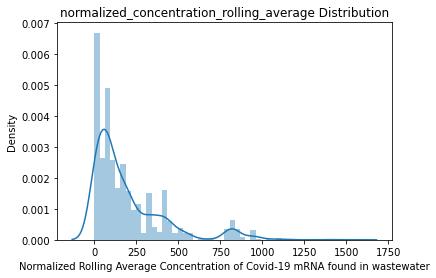

In [88]:
#This is NOT a normal distribution. Uh-oh...
sns.distplot(df.normalized_concentration_rolling_average)
plt.xlabel('Normalized Rolling Average Concentration of Covid-19 mRNA found in wastewater')
plt.title('normalized_concentration_rolling_average Distribution')

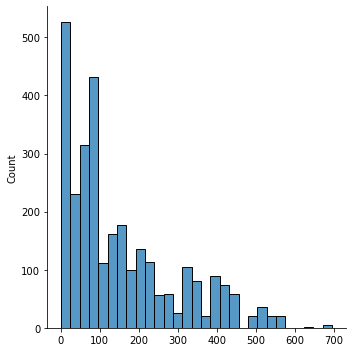

In [89]:
#setting a threshold of less than 700 to see if I can yield a more normal dist
data = [x for x in df.normalized_concentration_rolling_average if x <700]
sns.displot(data)

### Setting a threshold did not change the nature of the distribution. Needs work (in preprocessing)

In [ ]:
#Move to pre-processing
#transforming avg_concentration to be more Gaussian by using Box-Cox
import scipy.stats as stats
df2 = pd.DataFrame(df.loc[~(df.avg_concentration == 0)]) #filter out for zeroes
data = stats.boxcox(df2.avg_concentration)
df2['boxcox'] = data[0]

#plotting boxcox transformation of avg_concentration
sns.displot(data=df2, x=df2.boxcox)
plt.xlabel('Count')
plt.ylabel('avg_concentration')
plt.title('Box-Cox Power Transformed avg_concentration')

In [ ]:
#BoxCox could not process non-positivie (including zeroes).
#Yeo-Johnson may be a better transformation as there are no negative numbers
data = stats.yeojohnson(df.avg_concentration) #note this wasn't sliced for non-zero
df3 = df.copy()
df3['yeo'] = data[0]
sns.displot(data=df3, x=df3.yeo)
plt.ylabel('avg_concentration')
plt.xlabel('Count')
plt.title('Yeo-Johnson Power Transformed of avg_concentration')

In [ ]:
df2.yeo.max()

In [ ]:
#move to preprocessing
#checking whether the corr coefficients of transformed do better
df3.drop(columns=['population', 'County', 'City/Town'], inplace=True)
test = pd.get_dummies(df3)
test.corr()

In [ ]:
#The yeo-johnson transformed avg_concentration yields a better corr coefficient than boxcox
test.drop('boxcox', axis=1, inplace=True)

Text(0.5, 1.0, 'Percent Positivity Distribution')

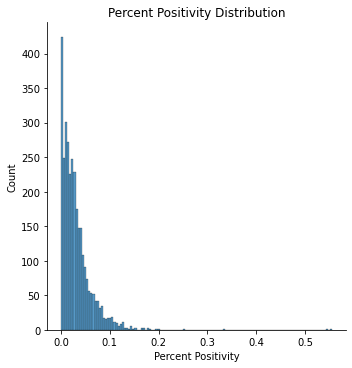

In [90]:
sns.displot(data=df, x='Percent Positivity')
plt.xlabel('Percent Positivity')
plt.title('Percent Positivity Distribution')

In [91]:
#Percent positivity distribution is not normal. May need to pre-process.
#possible transform ideas:
#1. Box Cox
#2. Yeo-Johnson

#There is a min val of 0, Box-Cox may not work on it
df['Percent Positivity'].describe()

count    3162.000000
mean        0.030726
std         0.031663
min         0.000000
25%         0.010101
50%         0.023529
75%         0.041790
max         0.555556
Name: Percent Positivity, dtype: float64

In [ ]:
#move to pre-processing

data = stats.yeojohnson(df['Percent Positivity'])
df4 = df3.copy()
df4['PP-Yeo'] = data[0]
sns.displot(data=df4, x='PP-Yeo')
plt.xlabel('Yeo-Johnson Percent Positivity')
plt.title('Yeo-Johnson Transformation of Percent Positivity')
df4[['yeo', 'PP-Yeo','avg_concentration']].corr()

In [ ]:
#move to modelling
#Using autocorrelation (because this is a time series!) to see if yeo-transformed avg_concentration 
#can forecast.
#trying to see a pattern to see least amount of days needed to forecast
#iterating through a week with 1 through 6 lagged days to forecast


#unpacking ax into an [3, 2] array to be called later in .plot_acf() 
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsaplots
fig, [[ax1, ax2], [ax3, ax4], [ax5, ax6]] = plt.subplots(nrows=3, ncols=2, 
                                                         sharex=True, sharey=True,
                                                         figsize=(21,9))
axList = [ax1, ax2, ax3, ax4, ax5, ax6]

for x in range(1,7):
    ac=sm.tsa.acf(df4.yeo, nlags=x, fft=True)
    y = x-1
    tsaplots.plot_acf(ac, ax=axList[y])
plt.tight_layout()
plt.show()

#maybe 6 days needed? Will need a windowing function. Perhaps a weighted one.

In [ ]:
#Move to modelling
#Using autocorrelation (because this is a time series!) to see if yeo-transformed Percentage Positivity can forecast
ac = sm.tsa.acf(df4['PP-Yeo'], nlags=21, fft=False)
fig = tsaplots.plot_acf(ac)
plt.show()

In [ ]:
#move to modelling
dummies = pd.get_dummies(df['Change Since Last Week'], prefix='Since Last Week')
#period = pd.Series(df.per)
#date = pd.Series(df['Report Date'])
#dummy_df = pd.DataFrame([date, period, dummies])
dummy_df = pd.DataFrame(dummies.merge(df['Report Date'], left_index=True, right_index=True))

In [ ]:
#move to modelling
ac = sm.tsa.acf(dummy_df['Since Last Week_Higher'], nlags=14, fft=False)
fig = tsaplots.plot_acf(ac)
plt.show()

<AxesSubplot:xlabel='Change Since Last Week', ylabel='normalized_concentration_rolling_average'>

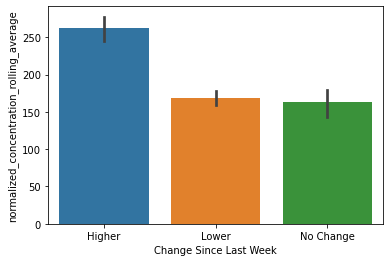

In [93]:
sns.barplot(data = df, x='Change Since Last Week', y=df.normalized_concentration_rolling_average)

### Distribution takeaways:
1. Concentration and Positivity are not uniform, shows skewedness
2. In Change Since the majority of the datapoints are 'lower'
3. in Change Since, the 'Higher' category seems to have the higher avg_concentration values

Let's explore any correlation gained from this insight.

In [ ]:
#I need to drop some features or my system won't be able to process the dummy variables for the .corr()

#Why did I think I needed to drop these features?
test = pd.DataFrame(df.drop(columns=['City/Town', 'County', 'population']))
#test = df.copy()

#test = pd.DataFrame(df.drop(columns=['population']))

In [ ]:
#I know dummies should be reserved to pre-processing but I couldn't help myself
test = pd.get_dummies(test)

In [ ]:
plt.figure(figsize = (21,9))
sns.heatmap(test.corr(), annot=True)

The heatmap is a great visual tool, as it looks at all the non-categorical data, and with the right parameters even annotates their Pearson r value.

In [ ]:
#If I didn't want that great visualization...
test.corr()

There is a mild correlation (0.446349) between avg_concentration and Percent Positivity. 

There is a weak correlation (0.197764) between avg_concentration and a Higher Change Since Last Week

### Using graphs can be a powerful tool to gain insight into the relationship between features.

Text(0.5, 1.0, 'Percent Positivity of the Surveiled Counties')

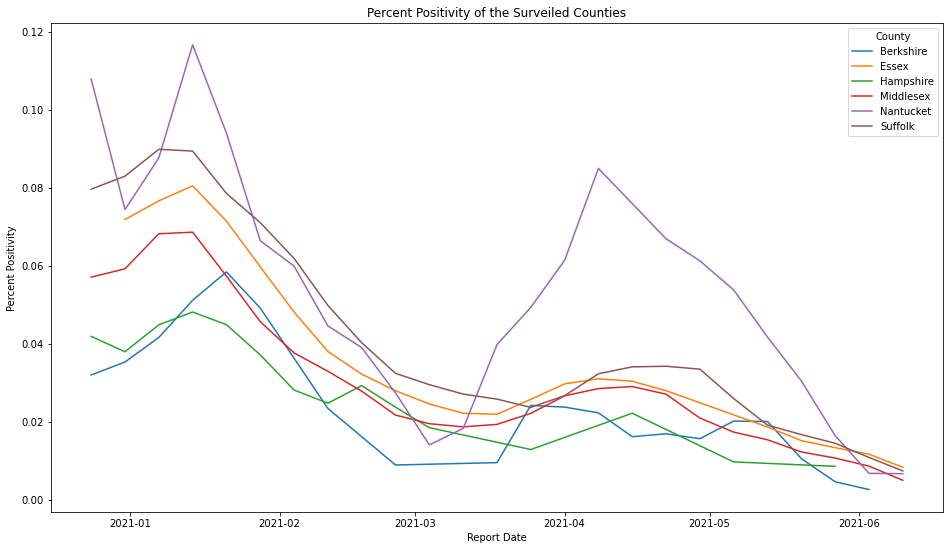

In [94]:
plt.figure(figsize=(16,9))
sns.lineplot(y='Percent Positivity', x=df['Report Date'], data=df, hue='County', ax=None, ci=None)
plt.title('Percent Positivity of the Surveiled Counties')

Some subject matter understanding of the vaccination rollouts will explain the downward trend in early 2021, and the vaccine hesitancy and resistance coupled with variants being introduced could explain the upward trends seen after March 2021.

Text(0.5, 1.0, 'Normalized Concentration of Rolling Average of Covid-19 mRNA found in Wastewater')

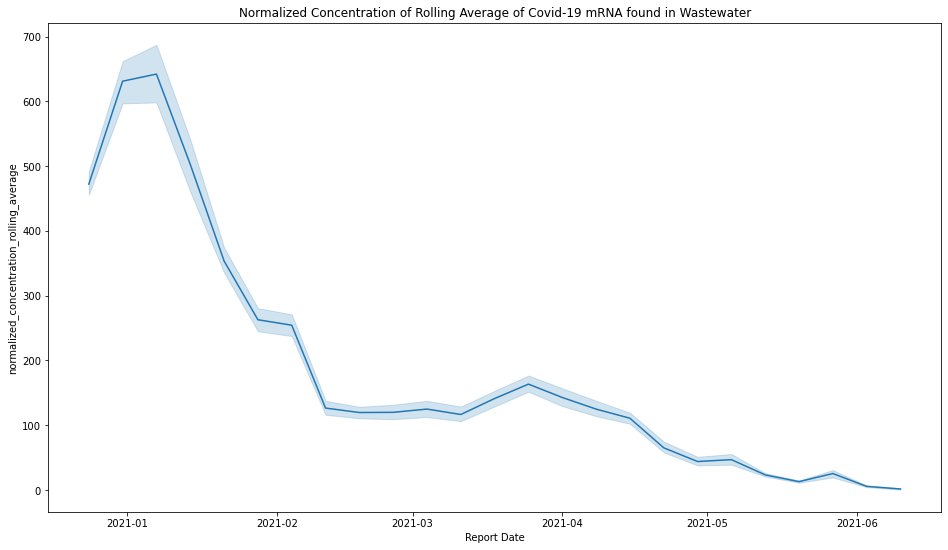

In [95]:
plt.figure(figsize=(16,9))
sns.lineplot(y='normalized_concentration_rolling_average', x=df['Report Date'], data=df)
plt.title('Normalized Concentration of Rolling Average of Covid-19 mRNA found in Wastewater')

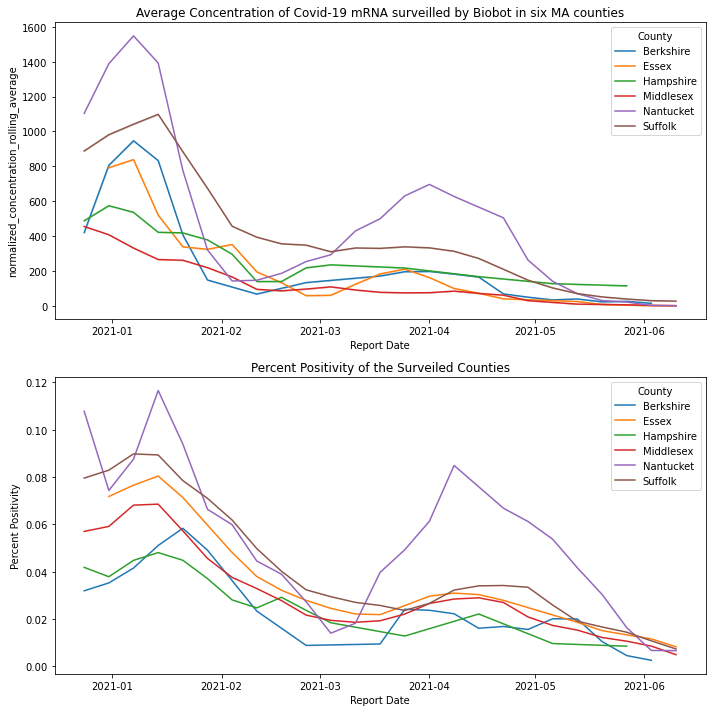

In [103]:
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(10,10))
sns.lineplot(data=df, x=df['Report Date'], y='normalized_concentration_rolling_average', hue='County', ax=ax1)
ax1.set_title('Average Concentration of Covid-19 mRNA surveilled by Biobot in six MA counties')
                               
sns.lineplot(y='Percent Positivity', x=df['Report Date'], data=df, hue='County', ax=ax2, ci=None)
ax2.set_title('Percent Positivity of the Surveiled Counties')

plt.tight_layout()
plt.show()

### Insight: 
1. Both are showing trends
2. 

In [ ]:
plt.figure(figsize=(16,9))
sns.scatterplot(data = df, x=df['Percent Positivity'], y=df.avg_concentration)
sns.regplot(data = df, x=df['Percent Positivity'], y=df.avg_concentration)
plt.title('Percent Positivity and MWRA Concentration Scatter Plot')
df.avg_concentration.corr(df['Percent Positivity']).round(5)

In [ ]:
test = df.copy()

#### Adding a column that shows the percent change of the average concentration from last week

In [ ]:
test['concentration_pct_change'] = test.avg_concentration.pct_change(periods=1)*100

In [ ]:
test.loc[test['County']=='Nantucket', ['Report Date', 
                                      'Change Since Last Week', 
                                      'Percent Positivity', 
                                      'avg_concentration', 
                                      'concentration_pct_change']]

### I had a hunch. Could I see more patterns in the data if...
1. I grouped it by county/city
2. Look at it as a time series

In [ ]:
slice = ['County', 'City/Town', 'population',
         'Report Date', 'Change Since Last Week', 
         'Percent Positivity', 'avg_concentration', 
         'concentration_pct_change']
hunch = pd.DataFrame(test[slice])


In [ ]:
hunch.info()

In [ ]:
hunch.set_index('Report Date', drop=True, inplace=True)
hunch.sort_index()

In [ ]:
#how many are null values
print('Np.nan\n', hunch.loc[hunch.values== np.nan].sum())


#how many have inf values
print('\nNp.inf\n', hunch.loc[hunch.values== np.inf].sum())

#### Some observation has a negative infinity in their features.
Locate.

In [ ]:
#above we see 'concentration_pct_change' has np.inf in them

#slicing all obs where 'concentration_pct_change' equals pos and neg inf
pos_inf = hunch['concentration_pct_change'] == np.inf
neg_inf = hunch['concentration_pct_change'] == -np.inf

#bitwise 'OR' slice 
hunch.loc[(pos_inf ^ neg_inf)]

#too long, look above for shorter code
#hunch.loc[((hunch['concentration_pct_change'] == np.inf) ^ (hunch['concentration_pct_change'] == -np.inf))]
    

Replace np.inf (both sides of infinity)

In [ ]:
hunch.replace([np.inf, -np.inf], np.nan, inplace=True)
hunch.loc[(pos_inf ^ neg_inf)]

In [ ]:
#how many are null values
print('Np.nan\n', hunch.loc[hunch.values== np.nan].sum())


#how many have inf values
print('\nNp.inf\n', hunch.loc[hunch.values== np.inf].sum())

In [ ]:
hunch.dropna(inplace=True)
hunch.shape

In [ ]:
hunch.concentration_pct_change.max() #that's a pretty large number. Dropping
#replace_this = hunch.loc[hunch.concentration_pct_change == hunch.concentration_pct_change.max()]
#hunch.replace(hunch.concentration_pct_change.max(), np.nan)
#print('Np.nan\n', hunch.loc[hunch.values== np.nan].sum())
test_num = hunch.concentration_pct_change.max()


In [ ]:
hunch.replace(test_num, np.nan, inplace=True)

In [ ]:
hunch.concentration_pct_change.max()

In [ ]:
#hunch.reset_index(inplace=True)

In [ ]:
c_list = []
for county in hunch.County:
    if county not in c_list: c_list.append(county)

In [ ]:
c_list

In [ ]:
test_dict = dict(zip([county for county in c_list], [hunch[hunch['County']==county] for county in c_list]))

In [ ]:
fig,  ax = plt.subplots(len(test_dict.keys()),1, figsize=(9,20))

In [ ]:
#I am trying to plot a seaborn linegraph where 6 subplots are generated, and on each subplot the avg_concenentration 
#by county is grouped by city/town
import random
fig, ax[[i for i in range(len(test_dict.keys()))]] = plt.subplots(len(test_dict.keys()),1, figsize=(9,20))

for counter, (county, dataframe) in enumerate(test_dict.items()):
    color = random.choice(['blue', 'red', 'green', 'black', 'yellow', 'orange', 'brown'])
    ax[counter].set_title(str(county) + ' County Pct Positivity Time Series')
    ax[counter].grid(True)
    sns.lineplot(data=dataframe, x='Report Date', y='Percent Positivity', ax=ax[counter], color=color,label='Pct Pos')
    ax2 = ax[counter].twinx()
    #ax2 = plt.twinx(ax[counter])
    sns.lineplot(data=dataframe, x='Report Date', y='avg_concentration', ax=ax2, marker='o')

    #fig.autofmt_xdate()
    plt.tight_layout()


In [ ]:
timeslice = pd.DataFrame(hunch.loc['2021-03-05':'2021-07-31'])

In [ ]:
sns.lineplot(data=timeslice, x='Report Date', y='Percent Positivity')
plt.tight_layout()

In [ ]:
timeslice['MA_6'] = timeslice.avg_concentration.rolling(window=3).mean().shift()
timeslice['MA_30'] = timeslice.avg_concentration.rolling(window=30).mean()

In [ ]:
df1 = df.copy()

#creating windowing functions
df1['MA_7'] = df1.avg_concentration.rolling(window=7).mean().shift(-6)
df1['MA_14'] = df1.avg_concentration.rolling(window=14).mean().shift(-13)
df1['Volatility_7'] = df1.avg_concentration.rolling(window=7, center=True).std().shift(-6)
df1['Volatility_14'] = df1.avg_concentration.rolling(window=14, center=True).std().shift(-13)

In [ ]:
df1.set_index('Report Date', inplace=True)

In [ ]:
figure, ax = plt.subplots(figsize=(21,9))
plt.grid(True)
#this first one was 'avg_concentration'
sns.lineplot(data = df, x=df1.index, 
             y=df1['Percent Positivity'], color='red')

#sns.lineplot(data = df, 
#             x=df1.index, 
#             y=df1['MA_7'], 
#             label='Moving Average 6-Days')
#sns.lineplot(data = df, 
#             x=df1.index, 
#             y=df1['MA_14'], 
#             label='Moving Average 14-Days')
ax2=plt.twinx(ax)
sns.lineplot(data = df, 
             x=df1.index, 
             y=df1['Volatility_7'], 
             label='Volatility 6-Days',
             ax=ax2, marker='o', ci=False)
sns.lineplot(data = df, 
             x=df1.index, 
             y=df1['Volatility_14'], 
             label='Volatility 14-Days',
             ax=ax2, marker='o',  ci=False)
plt.legend()
plt.ylabel('Volatility')
plt.title('Percent Positivity vs 6 and 14 Day Volatility')
plt.plot()

In [ ]:
figure, ax = plt.subplots(figsize=(21,9))
plt.grid(True)
#this first one was 'avg_concentration'
sns.lineplot(data = df, x=df1.index, 
             y=df1['avg_concentration'], color='red')


ax2=plt.twinx(ax)
sns.lineplot(data = df, 
             x=df1.index, 
             y=df1['MA_7'], 
             label='Moving Average 6-Days', marker='o', ci=False, ax=ax2)
sns.lineplot(data = df, 
             x=df1.index, 
             y=df1['MA_14'], 
             label='Moving Average 14-Days', marker='o', ci=False, ax=ax2)
#sns.lineplot(data = df, 
#             x=df1.index, 
#             y=df1['Volatility_7'], 
#             label='Volatility 6-Days',
#             ax=ax2, marker='o', ci=False)
#sns.lineplot(data = df, 
#             x=df1.index, 
#             y=df1['Volatility_14'], 
#             label='Volatility 14-Days',
#             ax=ax2, marker='o',  ci=False)
plt.ylabel('Moving Average')
plt.legend()
plt.title('Average Concentration of Covid-19 mRNA vs 6 and 14 Day Moving Averages')
plt.plot()

In [ ]:
#I created this method because I found it tedious to keep on slicing city data using pandas .loc
#By using this method, I can call up the data using a dict indexing such as dict[city_name]
def extract_city_from_df(df, column, the_slice, dictionary):
    '''Extract specific slices based on the specified city'''
    for city in df[column].unique():
        #city_dict.get(df.loc[df[column] == city, the_slice], city)
        if the_slice == None:
            dictionary[city] = df.loc[df[column] == city].set_index('Report Date', drop=True).copy()
        else:
            dictionary[city] = df.loc[df[column] == city, the_slice].set_index('Report Date', drop=True).copy()
    print('There were {} cities extracted to the dictionary from the DataFrame'.format(len(city_dict.keys())))
    return dictionary

In [ ]:
def city_MA_plot(dataFrame_dict, city, est_color, compared_feature, start_slice, end_slice):
    '''This method is to easily plot avg_concentration against another feature from a dict of the df, 
        with a specific label and color and time slice
        
        Parameters:
        dataFrame_dict: a dictionary type containing k:v of city:wrangled df of city
        city: the specific city data you want to graph
        est_color: The color wished displayed for the compared feature
        compared_feature: what you want to graph against avg_concentration
        start_slice: (Optional) Can leave as None or ''. Where to start the timeslce
        end_slice: (Optional): Where to end the timeslice
        '''
    
    cities = dataFrame_dict
    
    #Filter 
    assert str(city) in cities.keys(), 'That city is not in the dictionary.'
    assert compared_feature in cities[city].columns, 'That feature does not exist in the dataframe.'
    
    if start_slice=='' or end_slice=='':
        sns.lineplot(data=cities[city], x='Report Date', 
                     y='avg_concentration')
        sns.lineplot(data=cities[city], x='Report Date', y=str(compared_feature), 
                     color=str(est_color), label=compared_feature)
            
    else:
        sns.lineplot(data=cities[city].loc[start_slice:end_slice], 
                     x='Report Date', y='avg_concentration')
        sns.lineplot(data=cities[city].loc[start_slice:end_slice], 
                     x='Report Date', y=str(compared_feature), 
                     color=str(est_color), label=compared_feature)
    plt.title('Average Concentration compared to ' + str(compared_feature) +  ' feature')

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
city_MA_plot(cities, 'Cambridge', 'black', 'rolling', 'February 2021', 'August 2021')

In [ ]:
sns.catplot(data=df, x='Report Date', y='Change Since Last Week')

stopped here to sleep. I think I am in a better position to do ARMA now.

In [ ]:
df

In [ ]:
sns.catplot(data = df, x='County', y='avg_concentration')

In [ ]:
sns.catplot(data = df, x='Change Since Last Week', y='avg_concentration')

In [ ]:
sns.boxplot(data=df, x='County', y='avg_concentration')

## Notes to Luka for Review

The three line plots seems to have some kind of time-series trend that are in tandem with each other.

Thoughts on time-series possibilities:
1. AR, MA, or ARMA models
2. Auto-correlation whilst looking at various lag values
3. Probably should test for unit root stationarity.

The scatter plots, while showing large variability, a regression line still showed some positive correlation.

What I worry about is how those outliers seen in the scatterplots may be affecting the calculated correlation coefficients. Must discuss with Luka. 

Finally, I did some preprocessing ahead of schedule to see the correlation between 'Change Since Last Week' and the 'mwra_concentration' features. Whil they aren't the strongest, concentration hass the highest rated correlation coefficient.

I think I will pursue with concentration and Change Since.

### Here are my Null and Alternate Hypothesis to test:

#### H0: The concentration of covid-19 rna in sewage does not either Positivity Percentage or Change Since Last Week.

#### H-Alternate: The concentration of Covid-19 rna surveilled in sewage does affect Positivity Percentage or Change Since Last Week.


#### Discuss with Luka:
Do I need to set my p-value here? Howabout the level of significance, or the power needed to support these hypotheses?

In [ ]:
df

In [ ]:
#Saving current df for next Capstone 2 Unit
df.to_pickle('Unit16FeatureEngineering.pkl') #Commenting out for Github commit

# Pre-processing (Unit 16.3)

## Goals from the rubric:
1. Create dummy features
2. Scale standardization
3. Split data into training and testing subsets

### Create Dummy features
I did this earlier, and will copy the commented out code here for mentor review.

In [ ]:
#Converted object types into categorical dtypes
'''
def conversion(df, conversion_list):
    '''Method to convert my features into their appropriate datatypes'''
    for list in conversion_list:
        for col in list:
            if col in int64_list:
                df[col] = df[col].astype('int64')
            if col in category_list:
                df[col] = df[col].astype('category')
            if col in float64_list:
                df[col] = df[col].astype('float64')
'''
# I converted the following features:
# Color, Change Since Last Week, Change in Last Week

#Created dummy variables for thes categorical features:
# Change Since Last Week and Change in Last Week

'''
test = pd.get_dummies(df['Change Since Last Week'], prefix='Since Last Week', prefix_sep='-')
test1 = pd.get_dummies(df['Change in Last Week'], prefix='In Last Week', prefix_sep='-')
'''

#Merged my main df with these two dummy-added dfs
'''
test_df = df.copy()
merged_test1 = pd.merge(test_df, test, how='inner', right_index=True, left_index=True)
merged_test = pd.merge(merged_test1, test1, how='inner', right_index=True, left_index=True)
'''

# Finally I updated the main dataframe
'''
df = merged_test
'''

In [ ]:
#load pickle for this unit
with open('Unit16FeatureEngineering.pkl', 'rb') as f:
    df = pickle.load(f)
    
df.info()

In [ ]:
#Since I've already pre-processed dummy variables for Change Since, and Change in, should drop those two features
#Also dropping colors
df.drop(columns=['Change in Last Week', 'Change Since Last Week', 'Color'], inplace=True)

In [ ]:
df.info()

In [ ]:
preprocessed_df = df.select_dtypes(exclude=['uint8'])
df = preprocessed_df

## Addressing Stationarity:
I know it is a timeseries dataset. I have to test for stationarity with these tests:
1. Does it show a trend?
2. Does it show cyclicality or seasonality?
3. Does the variance change with time?
4. Does the dynamics change with time?

Let's look at 'avg_concentration' and then apply the Dicky-Fuller test.

In [ ]:
import statsmodels.api as sm

In [ ]:
df

In [ ]:
sns.lineplot(data=df, x=df.index,y=df['avg_concentration'])

In [ ]:
results = sm.tsa.stattools.adfuller(df['avg_concentration'])

## Have to partition the testing and training subsets.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import random

#this split is to test out 'Percent Positivity'
independent_variables = [col for col in preprocessed_df.columns if col != 'Percent Positivity']
print(independent_variables)
X = df[independent_variables] #these are independent variables

y = df['Percent Positivity'] #this is what I want to predict (Dependent variable)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

In [ ]:
# From experience, I should check the shapes of the splits
# to see if they match dimensions

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

### Before we test out any models, we should scale our features!

In [ ]:
scaler = MinMaxScaler()
scaled_X_train= scaler.fit_transform(X_train)
scaled_X_test = scaler.fit_transform(X_test)

In [ ]:
scaled_X_train.shape

In [ ]:
#let's try some models!
from sklearn import linear_model

model = linear_model.LinearRegression()
model.fit(scaled_X_train,y_train)
y_pred = model.predict(X_test)

In [ ]:
max(model.coef_)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
mean_squared_error(y_test, y_pred)

In [ ]:
r2_score(y_test, y_pred)

In [ ]:
#yikes! Let's try a logistic regression to predict "Change Since Last Week"

no_int8_df = df.select_dtypes(exclude=['uint8']) #excludes all the dummy features
independent_variables = no_int8_df.columns

X = df[independent_variables] #these are independent variables
y = df['Since Last Week-Higher'] #this is what I want to predict (Dependent variable)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=0)
#X_train = X_train.values.reshape(-1, 1)
#X_test = X_test.values.reshape(-1,1)
scaler = MinMaxScaler()
scaled_X_train= scaler.fit_transform(X_train)
scaled_X_test = scaler.fit_transform(X_test)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [ ]:
from sklearn.linear_model import LogisticRegressionCV 
model = LogisticRegressionCV(cv=5)
lr = model.fit(scaled_X_train, y_train)
y_pred = lr.predict(scaled_X_test)

In [ ]:
np.sum(y_pred==y_test) / len(y_pred)

In [ ]:
lr.coef_

In [ ]:
y_pred

In [ ]:
len(y_pred)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

